## What's Cooking? Kaggle comp and CDA final project 

#### Description
Picture yourself strolling through your local, open-air market... What do you see? What do you smell? What will you make for dinner tonight?

If you're in Northern California, you'll be walking past the inevitable bushels of leafy greens, spiked with dark purple kale and the bright pinks and yellows of chard. Across the world in South Korea, mounds of bright red kimchi greet you, while the smell of the sea draws your attention to squids squirming nearby. India’s market is perhaps the most colorful, awash in the rich hues and aromas of dozens of spices: turmeric, star anise, poppy seeds, and garam masala as far as the eye can see.

Some of our strongest geographic and cultural associations are tied to a region's local foods. This playground competitions asks you to predict the category of a dish's cuisine given a list of its ingredients. 

Acknowledgements: 
We want to thank Yummly for providing this unique dataset. Kaggle is hosting this playground competition for fun and practice.

#### The dataset
In the dataset, we include the recipe id, the type of cuisine, and the list of ingredients of each recipe (of variable length). The data is stored in JSON format. 

In [132]:
import pandas as pd
import numpy as np
from collections import Counter

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [26]:
train = pd.read_json('train.json')

In [27]:
train.head()

,cuisine,id,ingredients
0,greek,10259,"[romaine lettuce, black olives, grape tomatoes..."
1,southern_us,25693,"[plain flour, ground pepper, salt, tomatoes, g..."
2,filipino,20130,"[eggs, pepper, salt, mayonaise, cooking oil, g..."
3,indian,22213,"[water, vegetable oil, wheat, salt]"
4,indian,13162,"[black pepper, shallots, cornflour, cayenne pe..."


This is a 'simple' dataset. We have the label (cuisine), the recipe id (which is for Yummly labelling and offers no real insight into the subject matter), and we have the list of ingredients. 

The focus of this study is on the list of ingredents. We will explore questions including:
* Do some cuisines use more ingredients than others?
* Which cuisines are the most similar? Most different?
* Which ingredients are commonly used across all cuisines?
* Which ingredients provide the best indicator of a recipe's cuisine?

And, of course, we will apply Machine Learning techniques to build a prediction engine that can determine the cuisine of a food based on a list of ingredients.

# EDA

### Basic Exploration

To begin with, we did some basic exploring. We can see that we have about 40,000 recipes in our dataset. 

In [28]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 39774 entries, 0 to 39773
Data columns (total 3 columns):
cuisine        39774 non-null object
id             39774 non-null int64
ingredients    39774 non-null object
dtypes: int64(1), object(2)
memory usage: 932.3+ KB


There are 20 cuisines. In the below summary we can see that Italian cuisine is 'over-represented' in this dataset, followed closely by Mexican and Southern_US. The dataset is, thus, unbalanced. We will come back to this before we begin ML. For now, it is interesting context for us. 

In [120]:
print(train['cuisine'].value_counts(normalize=True))
print(train['cuisine'].nunique())

italian         0.197147
mexican         0.161904
southern_us     0.108649
indian          0.075392
chinese         0.067242
french          0.066512
cajun_creole    0.038891
thai            0.038640
japanese        0.035721
greek           0.029533
spanish         0.024829
korean          0.020879
vietnamese      0.020729
moroccan        0.020653
british         0.020225
filipino        0.018993
irish           0.016779
jamaican        0.013232
russian         0.012301
brazilian       0.011748
Name: cuisine, dtype: float64
20


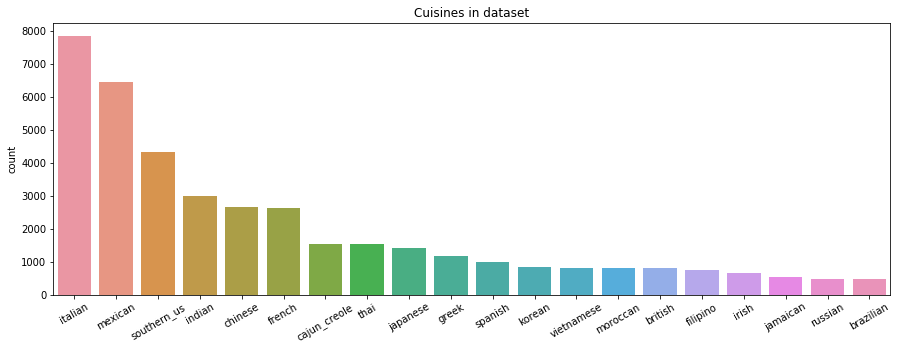

In [297]:
plt.figure(figsize = (15,5))
ax = sns.countplot(train['cuisine'], order = train['cuisine'].value_counts().index)
ax.set_xticklabels(ax.get_xticklabels(),rotation=30);
ax.set_title('Cuisines in dataset')
ax.set_xlabel('');

### Counting the number of ingredients per recipe

We created a 'number of ingredients' feature, ie. how many ingredients appear in each recipe. We hypothesise that this may be a contributing factor when predicting cuisine.

This new feature shows us:

* The average recipe length is 11 ingredients.
* The most complex recipe has 65 ingredients, while the simplest has only 1.
* The longest recipe is Italian.

In [35]:
train['number'] = [len(i) for i in train['ingredients']]
train.head()

,cuisine,id,ingredients,number
0,greek,10259,"[romaine lettuce, black olives, grape tomatoes...",9
1,southern_us,25693,"[plain flour, ground pepper, salt, tomatoes, g...",11
2,filipino,20130,"[eggs, pepper, salt, mayonaise, cooking oil, g...",12
3,indian,22213,"[water, vegetable oil, wheat, salt]",4
4,indian,13162,"[black pepper, shallots, cornflour, cayenne pe...",20


In [36]:
print('Maximum Number of Ingredients in a Dish: ',train['number'].max())
print('Minimum Number of Ingredients in a Dish: ',train['number'].min())

Maximum Number of Ingredients in a Dish:  65
Minimum Number of Ingredients in a Dish:  1


In [37]:
train['number'].describe()

count    39774.000000
mean        10.767713
std          4.428978
min          1.000000
25%          8.000000
50%         10.000000
75%         13.000000
max         65.000000
Name: number, dtype: float64

In [38]:
train['number'].median()
train.groupby('cuisine')['number'].median()

cuisine
brazilian        9
british          9
cajun_creole    12
chinese         12
filipino        10
french           9
greek           10
indian          12
irish            9
italian         10
jamaican        12
japanese         9
korean          11
mexican         10
moroccan        13
russian         10
southern_us      9
spanish         10
thai            12
vietnamese      12
Name: number, dtype: int64

In [39]:
print("Explore the ingredients in the longest recipe in our training set:" + "\n")
print(str(list(train[train['ingredients'].str.len() == 65].ingredients.values)) + "\n")
print("Cuisine: " + str(list(train[train['ingredients'].str.len() == 65].cuisine)))

Explore the ingredients in the longest recipe in our training set:

[['fettucine', 'fresh marjoram', 'minced garlic', 'olive oil', 'garlic powder', 'large eggs', 'Alfredo sauce', 'vegetable oil', 'cajun seasoning', 'shredded romano cheese', 'basil dried leaves', 'salt', 'cayenne pepper', 'scallions', 'red bell pepper', 'boneless skinless chicken breast halves', 'soba', 'pasta sauce', 'kosher salt', 'milk', 'fresh ginger', 'ground black pepper', 'flour', 'cooked chicken', 'coarse salt', 'lemon', 'diced tomatoes', 'garlic', 'rice vinegar', 'Neufchâtel', 'garlic cloves', 'dried parsley', 'frozen artichoke hearts', 'penne', 'pepper', 'sweet onion', 'part-skim mozzarella cheese', 'parmigiano reggiano cheese', 'basil leaves', 'onion powder', 'red wine vinegar', 'red pepper flakes', 'orzo', 'crushed red pepper', 'all-purpose flour', 'freshly ground pepper', 'sliced mushrooms', 'panko breadcrumbs', 'plum tomatoes', 'fresh basil', 'fresh leav spinach', 'water', 'sun-dried tomatoes', 'ground pep

### Dealing with 1-ingredient recipes

We have 22 recipes with only 1 ingredient. These 1-ingredient recipes are more likely to be Indian. A 1-ingredient recipe does not make much sense given the context of our study, and will mislead the algorithm to over-value these ingredients. We therefore discard these rows. 

In [40]:
train[train['number'] < 2]

,cuisine,id,ingredients,number
940,japanese,4734,[sushi rice],1
2088,vietnamese,7833,[dried rice noodles],1
6787,indian,36818,[plain low-fat yogurt],1
7011,indian,19772,[unsalted butter],1
8181,japanese,16116,[udon],1
8852,thai,29738,[sticky rice],1
8990,indian,41124,[butter],1
10506,mexican,32631,[corn tortillas],1
13178,thai,29570,[grained],1
17804,southern_us,29849,[lemonade concentrate],1


In [41]:
train[train['number'] < 2].shape

(22, 4)

In [42]:
train[train['number'] < 2].groupby('cuisine')['cuisine'].count()

cuisine
french         2
greek          1
indian         6
italian        1
japanese       3
mexican        2
southern_us    1
spanish        2
thai           3
vietnamese     1
Name: cuisine, dtype: int64

In [43]:
# removing 1-ingredient recipes leaves us with 39,752 observations

train = train[train['number'] > 1]
train.shape

(39752, 4)

### Exploring the relationship between recipe complexity and cuisine

Now that we have created a number field and removed 1-ingredient recipes, we can begin to explore the relationship between recipe complexity and cuisine. We already know that the longest recipe is Italian, but in the next section we also learn:
* We can see that, on average, the cuisines with the most ingredients are Moroccan (13), Indian (12), Vietanmese (12), Cajun (12) and Thai (12).

In [48]:
# create a dataframe grouped by cuisine to get average number of ingredients by cuisine, and sort

result = train.groupby(["cuisine"])['number'].mean().reset_index().sort_values('number', ascending = False)
result

,cuisine,number
14,moroccan,12.909866
7,indian,12.729396
19,vietnamese,12.689320
2,cajun_creole,12.617076
18,thai,12.568359
10,jamaican,12.214829
3,chinese,11.982791
12,korean,11.284337
13,mexican,10.880516
17,spanish,10.442756


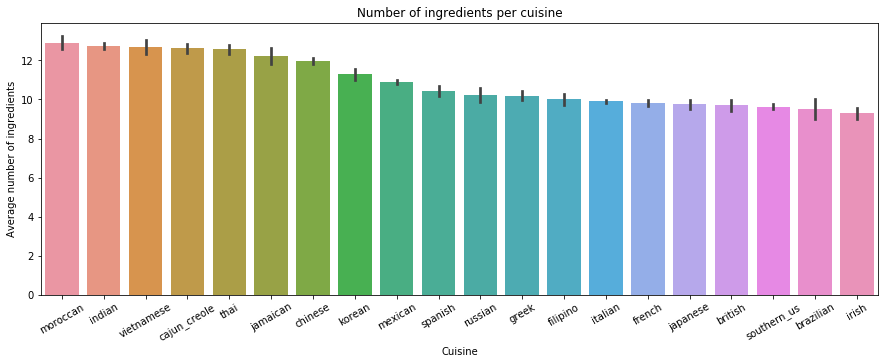

In [50]:
plt.figure(figsize = (15,5))
ax = sns.barplot(x = 'cuisine', y = 'number', data = train, order = result['cuisine'])
ax.set_xticklabels(ax.get_xticklabels(),rotation=30);
ax.set_title('Number of ingredients per cuisine')
ax.set_ylabel('Average number of ingredients')
ax.set_xlabel('Cuisine');


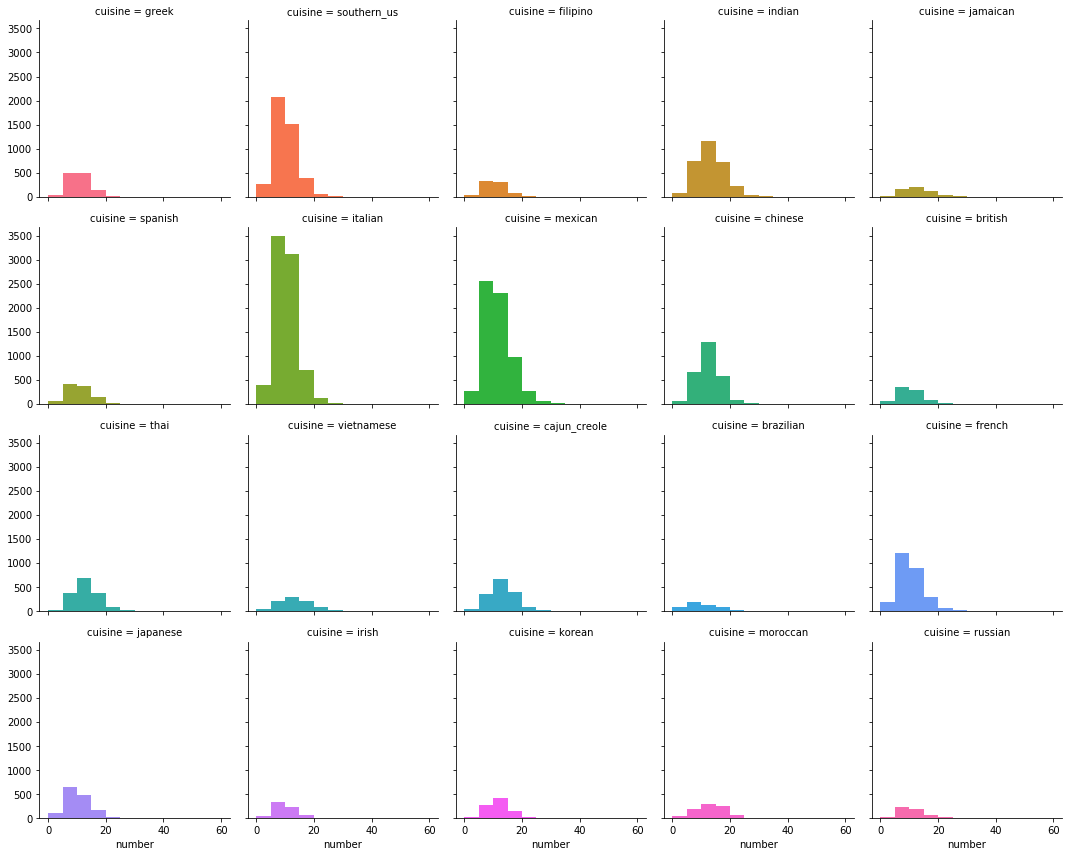

In [51]:
# can we normalize the below to improve cross-cuisine comparison?
# don't think this is a useful graph

g = sns.FacetGrid(train, col = "cuisine", col_wrap = 5, margin_titles=True, hue = 'cuisine')
bins = np.linspace(0, 60, 13)
g.map(plt.hist, "number", bins=bins);
#plt.axvline('number_ingredients'.mean(), color='k', linestyle='dashed', linewidth=1);

### Exploring the most commonly used ingredients

Now we begin to look at the counts of different ingredients to understand which are most commonly used.
Here we learn:
* There are 6714 unique ingredients in this dataset.
* Salt is the most ubiquitous ingredient, followed by oil and onions. These, along with the other most commonly used ingredients will have poor predictive power (we explore this later using tf-idf)
* 1759 ingredients only appear in 1 recipe. This may be because of some recipes specifying brands where others do not. We will not fix this at this point

### BUT SHOULD WE??????

In [ ]:
# can we instead do this by creating a column in the df? 

In [53]:
allingredients = [] # this list stores all the ingredients in all recipes (with duplicates)
for item in train['ingredients']:
    for ingr in item:
        allingredients.append(ingr) 

In [62]:
# converting to a dataframe 
ingredients_df = pd.DataFrame(allingredients, columns=['ingredient'])

In [63]:
# counting number of recipes with each ingredient
ingredients_df = ingredients_df.groupby('ingredient')['ingredient'].count().reset_index(name="count")
ingredients_df.head()

,ingredient,count
0,( oz.) tomato sauce,11
1,( oz.) tomato paste,9
2,(10 oz.) frozen chopped spinach,3
3,"(10 oz.) frozen chopped spinach, thawed and sq...",2
4,(14 oz.) sweetened condensed milk,2


In [68]:
# checking the modet commonly used 20 ingredients

print("The most commonly used ingredients (with counts) are:")
print("\n")
print(ingredients_df.nlargest(20, 'count'))
print("\n")
print("The number of unique ingredients in our training sample is: ", ingredients_df['ingredient'].nunique())

The most commonly used ingredients (with counts) are:


               ingredient  count
5309                 salt  18049
4343            olive oil   7972
4361               onions   7972
6435                water   7456
2884               garlic   7380
5888                sugar   6434
2890        garlic cloves   6237
1220               butter   4846
3135  ground black pepper   4785
555     all-purpose flour   4632
4569               pepper   4438
6375        vegetable oil   4384
2436                 eggs   3388
5744            soy sauce   3296
3591          kosher salt   3113
3102         green onions   3078
6146             tomatoes   3058
3641           large eggs   2948
1386              carrots   2814
6268      unsalted butter   2779


The number of unique ingredients in our training sample is:  6714


In [70]:
# checking the ingredients that only occur in one recipe

print("Ingredients that only occur in 1 recipe are:")
print("\n")
print(ingredients_df[ingredients_df['count'] == 1])

Ingredients that only occur in 1 recipe are:


                                             ingredient  count
12                             2% low fat cheddar chees      1
15                   2% milk shredded mozzarella cheese      1
18                      33% less sodium cooked deli ham      1
19                           33% less sodium cooked ham      1
21              33% less sodium smoked fully cooked ham      1
25                    8 ounc ziti pasta, cook and drain      1
27                         A Taste of Thai Rice Noodles      1
29                          Adobo All Purpose Seasoning      1
31                                  Alexia Waffle Fries      1
33                                     Amarena cherries      1
38                                     Argo Corn Starch      1
40                              Asian sweet chili sauce      1
41                               Azteca Flour Tortillas      1
42                        BACARDI® Mixers Margarita Mix      1
43      

### How many and which ingredients can be found in each cuisine

In [124]:
# Define a function that returns how many different ingredients can be found in all recipes for a given cuisine

def findnumingr(cuisine):
    listofinrg = []
    for item in train[train['cuisine'] == cuisine]['ingredients']:
        for ingr in item:
            listofinrg.append(ingr)
    result = (cuisine,len(list(set(listofinrg))))         
    return result 

In [125]:
cuisineallingr = []
for cuisine in train['cuisine'].unique():
    cuisineallingr.append(findnumingr(cuisine))

In [126]:
cuisineallingr.sort(key=lambda x: x[1])


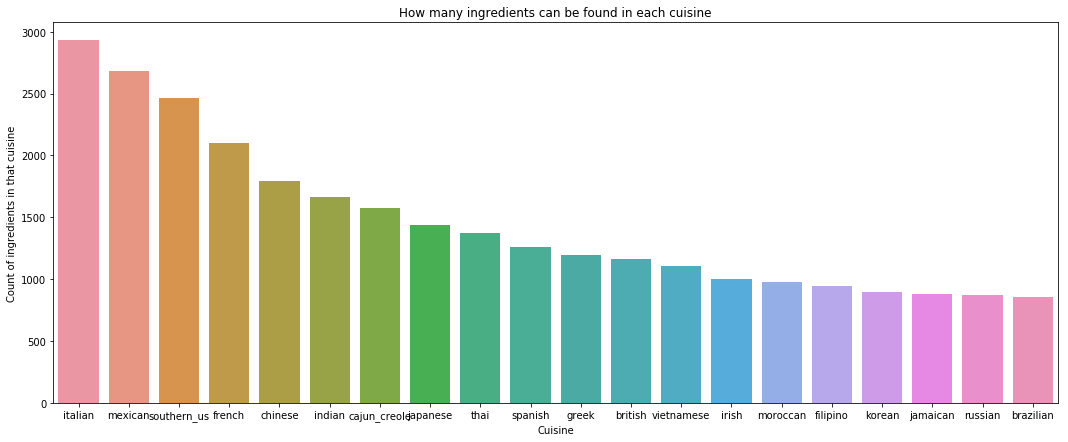

In [117]:
plt.figure(figsize=(18, 7))
sns.barplot(y = [i[1] for i in cuisineallingr], 
           x = [i[0] for i in cuisineallingr],
           order = cuisineallingr.sort(key=lambda x: x[1], reverse = False))
plt.xlabel('Cuisine')
plt.ylabel('Count of ingredients in that cuisine')
plt.title('How many ingredients can be found in each cuisine');

From the above bar chart, we can see that cuisines with more recipes in the training set do not always have more ingredients representing them.  For example, French cuisine is only 6.65% of he training set, but has more variability than Indian cuisine (which makes up 7.5%).

Now, we explore which ingredients are specific only to ONE cuisine (and will therefore have strong predictive power.)

In [123]:
# We used allingredients before (it's a list of all ingredients in the training sample, with duplication)
# Now we remove duplicates
allingredients = list(set(allingredients))

In [178]:
# Define a function that returns a dataframe with top 5 unique ingredients in a given cuisine 
def cuisine_unique(cuisine, allingredients):
    allother = []
    
    # create a list of ingredients that appear in other cuisines
    for item in train[train['cuisine'] != cuisine]['ingredients']:
        for ingr in item:
            allother.append(ingr)
    allother  = list(set(allother ))
    
    # compare allother to the full list in allingredients, and only keep ingredients that aren't in allother
    specificnonly = [x for x in allingredients if x not in allother]
    
    mycounter = Counter()
    
    # for every ingredient that appears in that cuisine, find number of associated recipes in that cuisine
    for item in train[train['cuisine'] == cuisine]['ingredients']:
        for ingr in item:
            mycounter[ingr] += 1
    keep = list(specificnonly)
    
    # only keep the recipe counts if that ingredient is unique to the cuisine
    for word in list(mycounter):
        if word not in keep:
            del mycounter[word]
    
    # create a dataframe that shows the recipe count for each ingredient unique to the cuisine
    cuisinespec = pd.DataFrame(mycounter.most_common(5), columns = ['ingredient','count'])
    cuisinespec['Cuisine'] = cuisine
    
    return cuisinespec

In [179]:
# So here we can see that gnocchi is the most unique ingredient to Italian cuisine
# It appears in no other cuisines, but in 41 Italian recipes

cuisine_unique('italian', allingredients)

,ingredient,count,Cuisine
0,gnocchi,41,italian
1,"lasagna noodles, cooked and drained",26,italian
2,bulk italian sausag,21,italian
3,potato gnocchi,20,italian
4,cheese ravioli,18,italian


In [180]:
# Now create a new dataframe with all of this information

unique_ing = pd.DataFrame()

for i in train['cuisine'].unique():
    unique_ing = unique_ing.append(cuisine_unique(i, allingredients))

In [181]:
unique_ing

,ingredient,count,Cuisine
0,ouzo,10,greek
1,kefalotyri,9,greek
2,greek-style vinaigrette,5,greek
3,pita loaves,5,greek
4,sliced kalamata olives,4,greek
0,collards,14,southern_us
1,buttermilk biscuits,12,southern_us
2,Nilla Wafers,10,southern_us
3,grit quick,8,southern_us
4,peaches in heavy syrup,6,southern_us


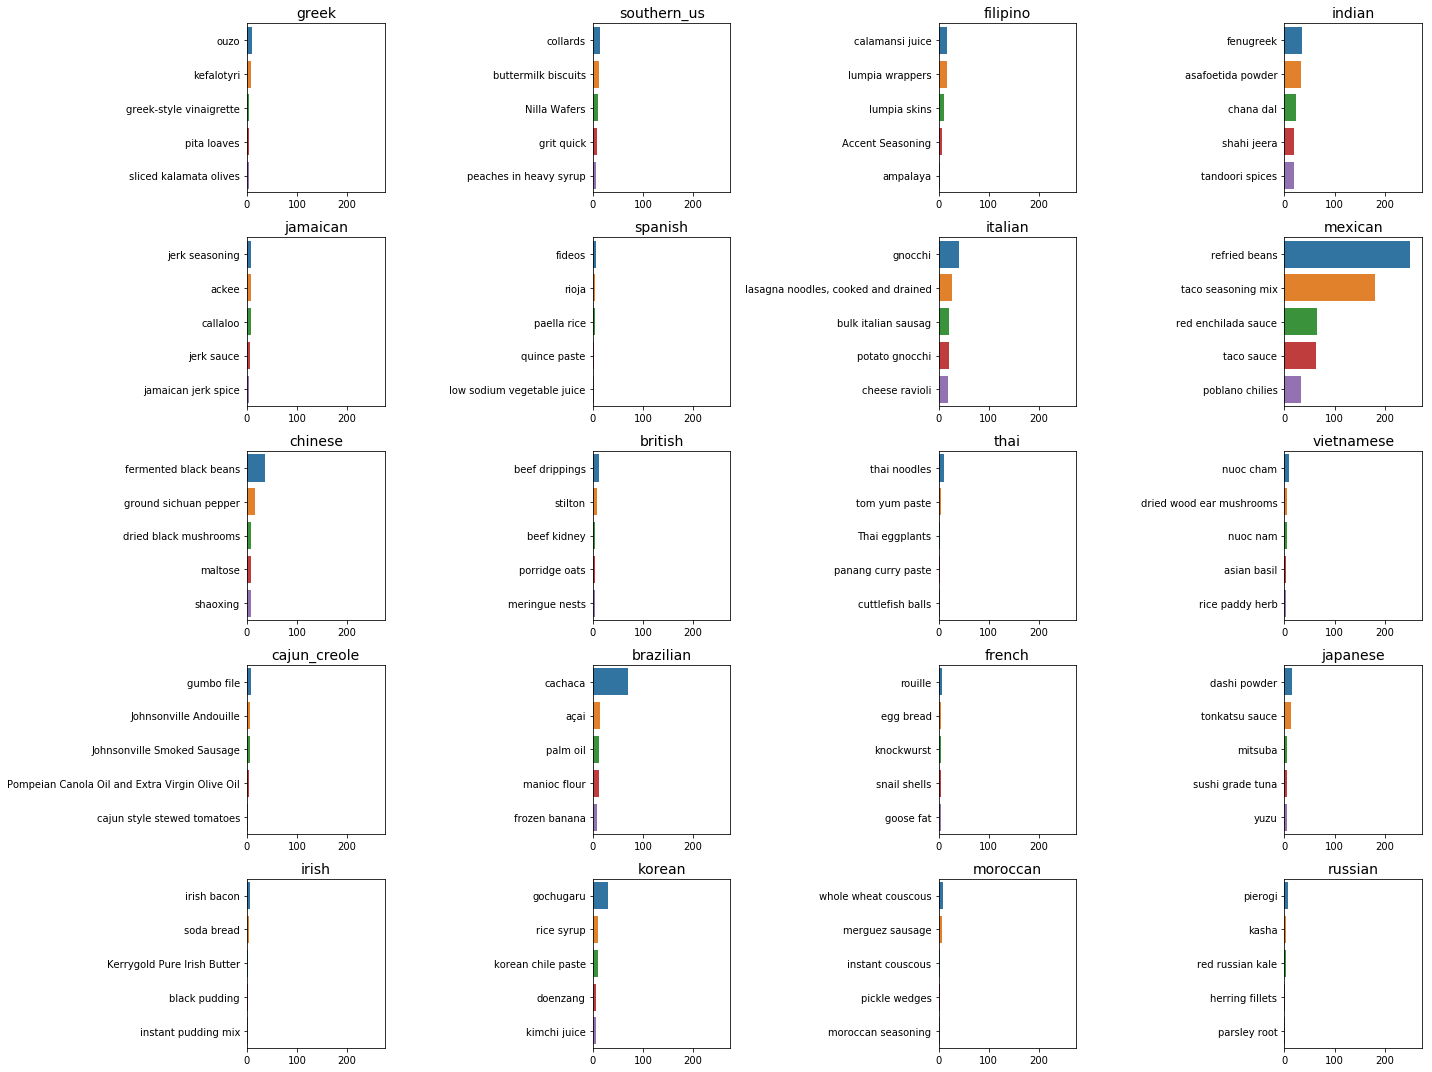

In [288]:
# plotting with each cuisine on the same xlim

fig, axes = plt.subplots(nrows = 5, ncols = 4,  figsize = (20, 15))
axes = axes.flatten()
for ax, cuisine in zip(axes, unique_ing['Cuisine'].unique()):
    sns.barplot(y = 'ingredient', 
                x = 'count', 
                data = unique_ing[unique_ing['Cuisine'] == cuisine],
                ax = ax)
    ax.set_title(cuisine, fontdict={'fontsize': 14})
    
for ax in axes:
    ax.set_ylabel('')
    ax.set_xlabel('')
    ax.set_xlim(0, 275)

plt.tight_layout()
#plt.title('Unique ingredients per cuisine');

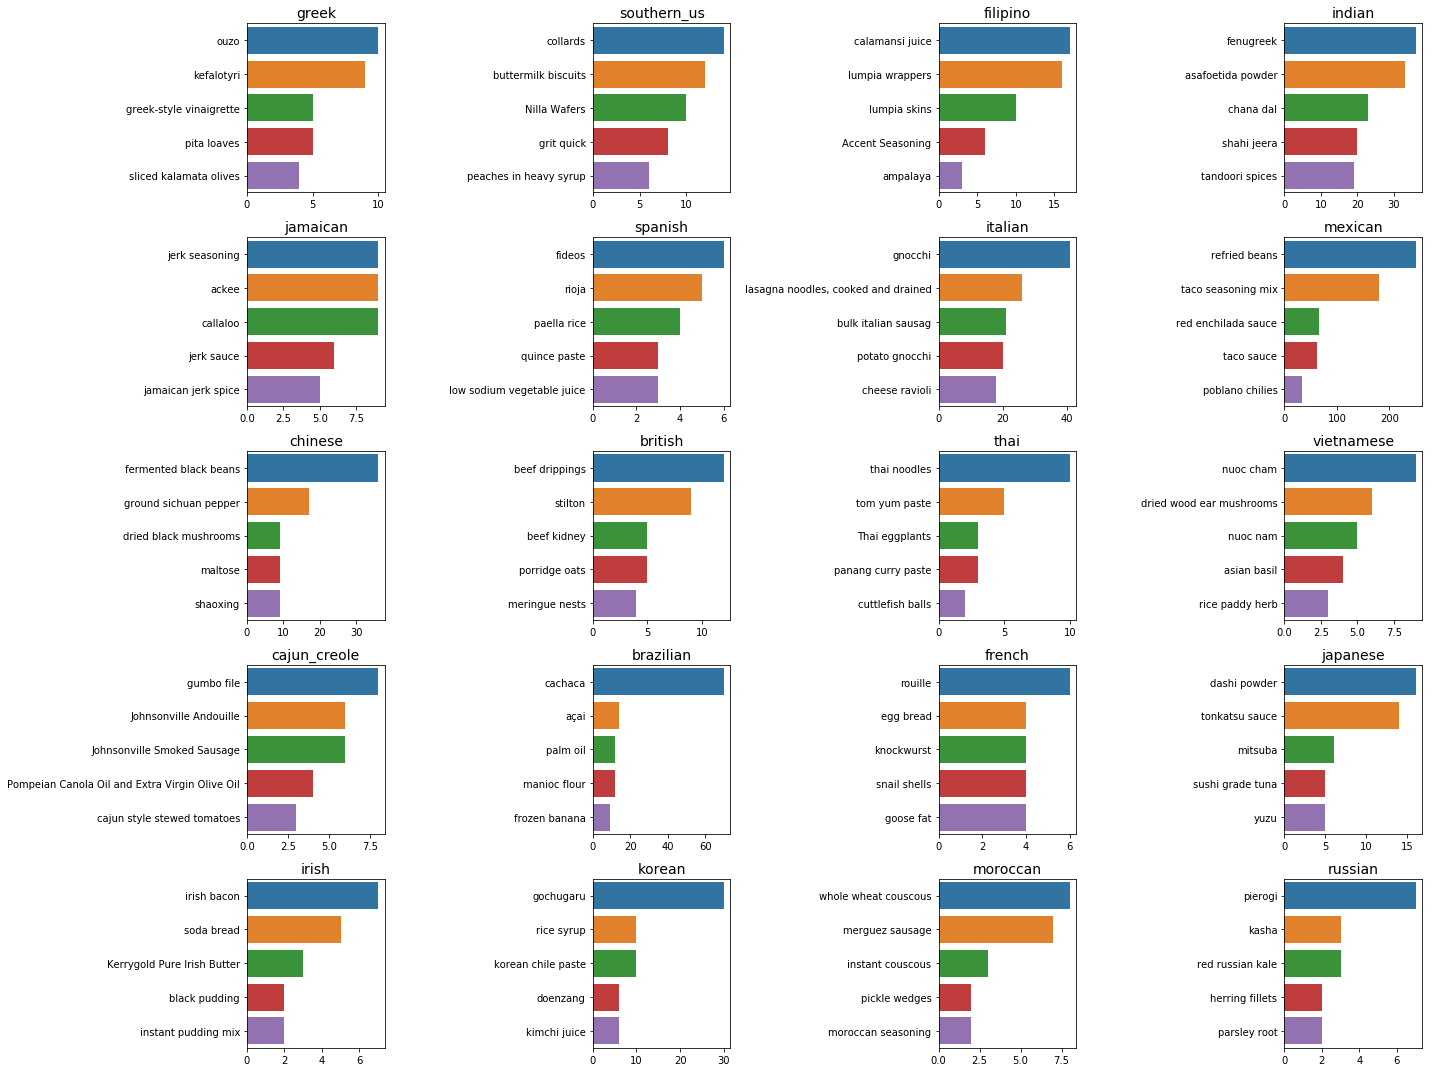

In [284]:
# And then again without forcing the xlim

fig, axes = plt.subplots(nrows = 5, ncols = 4,  figsize = (20, 15))
axes = axes.flatten()
for ax, cuisine in zip(axes, unique_ing['Cuisine'].unique()):
    sns.barplot(y = 'ingredient', 
                x = 'count', 
                data = unique_ing[unique_ing['Cuisine'] == cuisine],
                ax = ax)
    ax.set_title(cuisine, fontdict={'fontsize': 14})
    
for ax in axes:
    ax.set_ylabel('')
    ax.set_xlabel('')

plt.tight_layout()
#plt.title('Unique ingredients per cuisine');

The above plots show us quite a bit about how differentiated the cuisines are, and give us an indication of how eady/hard it will be to predict a cuisine based on its ingredients. 

* Mexican cuisine is the only one where the unique ingredients (mainly refried beans) are also highly represented across Mexican recipes; refried beans are found in more than 200 Mexican recipes in our dataset. We can expect that refried beans and taco seasoning will play an important role in predicting whether a cuisine is Mexican. 
* Cachaca is the next most important predictor for a cuisine, with more than 60 Brazilian recipes calling for this spirit
* Gnocchi is an important unique ingredient for Italian food (unsuprisingly) 
* Fenugreek is important and unique to Indian food
* Fermented black-beans is important for Chinese cuisine
* Gochugaru is unique to Korean
* The remaining cuisines may be harder to accurately predict based on ingredient presence, they had fewer recipes with ingredients unique to their style of cooking. 

We will drill in to this further using TfIdf, and of course, validate how well our cuisines can be predicted once we begin ML.

### Tf-Idf

Now that we have explored the data, and begun to understand some preliminary differences between the cuisines in terms of number of ingredients and key ingredients used, we can apply the tf-idf approach.  This allows us to uncover which ingredients are important to a specific cuisine, within our whole dataset. These will be ingredients that are frequently used in the recipes belonging to that cuisine and at the same time not so frequently used in the whole sample of recipes. 

In our case:
* Corpus = the What's cooking dataset
* Document = recipe
* Word = ingredient

Note that we are using the data as is - we have removed 1-ingredient recipes, and converting to lowercase, but that is the only cleaning. 

In [237]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import make_pipeline

In [238]:
model = make_pipeline(TfidfVectorizer(), MultinomialNB())

In [242]:
# list of all the recipes
features = [] 
for item in train['ingredients']:
    features.append(item)
len(features)

39752

In [243]:
# this is our vocabulary; all ingredients from all recipes (with duplicates)
ingredients = [] 
for item in train['ingredients']:
    for ingr in item:
        ingredients.append(ingr) 
len(ingredients)

428253

In [256]:
# Fit the TfidfVectorizer to data

tfidf = TfidfVectorizer(vocabulary= list(set([str(i).lower() for i in ingredients])))
X_tr = tfidf.fit_transform([str(i) for i in features]) # X_tr - matrix of tf-idf scores
feature_names = tfidf.get_feature_names()

# Define the target variable
cuisine = train['cuisine']

In [276]:
# Define a function for finding the most important features in a given cuisine according to Tf-Idf measure 
# We want to look at features only that have a min tfidf of 0.1 (ie. ignore any poor indicators of cuisine)
# We want to return the top 10 most important words/ingredients
# The output is a list of dataframes, one per cuisine, with top  ingredients

def top_feats_by_class(train, target, featurenames, min_tfidf=0.1, top_n=10):

    dfs = pd.DataFrame()
    labels = np.unique(target)
    
    for label in labels: # for each cuisine
        
        ids = np.where(target==label) 
        D = train[ids].toarray() # creates an array of ingredients from our matrix of tfidf scores related to the cuisine
        D[D < min_tfidf] = 0 # keeps only the ingredients that have tfidf greater than 0.1
        tfidf_means = np.nanmean(D, axis=0) # takes the average tfidf for each ingredient 
        
        topn_ids = np.argsort(tfidf_means)[::-1][:top_n] #  Get top n tfidf values
        top_feats = [(featurenames[i], tfidf_means[i]) for i in topn_ids] # find their corresponding feature names
        df = pd.DataFrame(top_feats) # put this all into a df 
        df.columns = ['ingredient', 'tfidf'] # rename for readability
        
        df['cuisine'] = label
        dfs = dfs.append(df)
        
    return dfs

In [277]:
result_tfidf = top_feats_by_class(X_tr, cuisine, feature_names, min_tfidf=0.1, top_n=5)
result_tfidf

,ingredient,tfidf,cuisine
0,milk,0.129405,brazilian
1,lime,0.099823,brazilian
2,cachaca,0.097021,brazilian
3,coconut,0.092772,brazilian
4,pepper,0.081172,brazilian
0,flour,0.130169,british
1,butter,0.116983,british
2,sugar,0.104654,british
3,eggs,0.096452,british
4,milk,0.096065,british


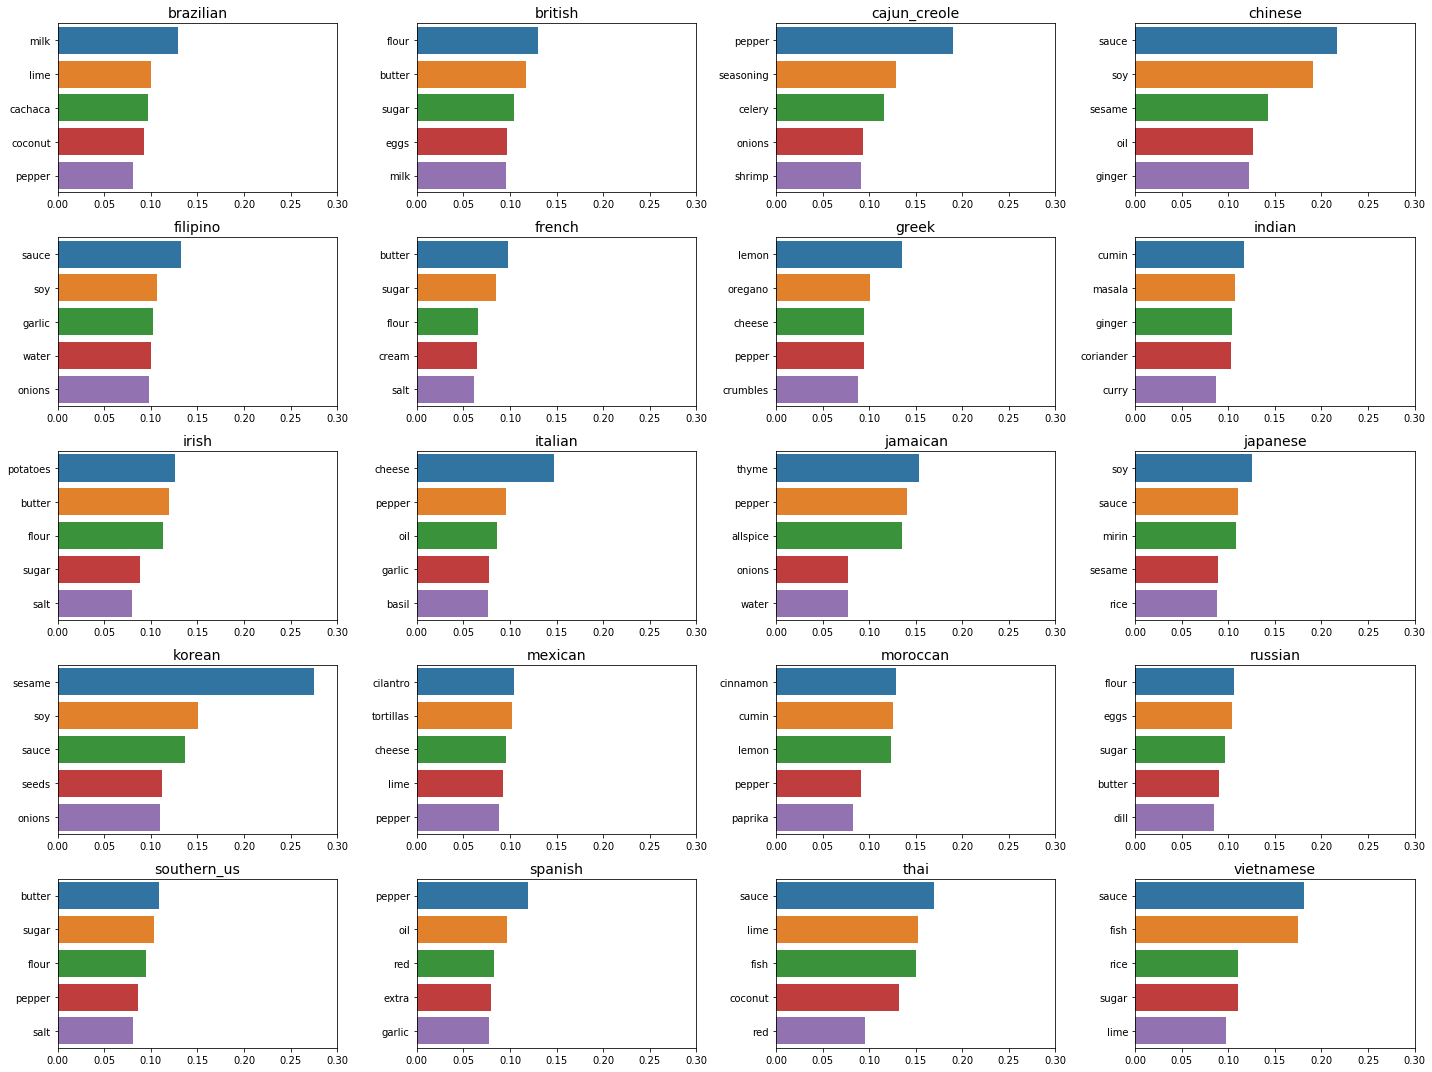

In [299]:
fig, axes = plt.subplots(nrows = 5, ncols = 4,  figsize = (20, 15))
axes = axes.flatten()
for ax, cuisine in zip(axes, result_tfidf['cuisine'].unique()):
    sns.barplot(y = 'ingredient', 
                x = 'tfidf', 
                data = result_tfidf[result_tfidf['cuisine'] == cuisine],
                ax = ax)
    ax.set_title(cuisine, fontdict={'fontsize': 14})
    
for ax in axes:
    ax.set_ylabel('')
    ax.set_xlabel('')
    ax.set_xlim(0, .3)

plt.tight_layout();
#plt.title('Ingredient importance based on tfidf');

# update this, it's plagiarized right now
 
From the vizualizations above we can make the following observations: 

several of our assumptions in this section of the analysis were accurate - cachaca is major ingredient in Brazilian recipes and tortillas are important in Mexican cuisine.
some of the important words appear in several cuisines, BUT still this observation holds true only if the cuisines are in the same region:
In Asian cuisines we find that fish, sauce, soy and sesame are all with higher tf-idf values;
butter, sugar, eggs and flour are found in several European cuisines;
Greek, Spanish and Italian cuisines all share olive oil and cheese.
another observation we can make is that different spices (rather than food like fruits, vegetables, fish or meat) dominate the Moroccan, Indian and Jamaican cuisines.

# Machine Learning

In [13]:
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import make_pipeline

In [14]:
# combine lists into single list for tokenization

train['ingredients'] = [' '.join(inner_list) for inner_list in train['ingredients']]

In [15]:
# create the transform
vectorizer = CountVectorizer()

In [16]:
# tokenize and build vocab
vectorizer.fit(train['ingredients'])

CountVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=None, min_df=1,
        ngram_range=(1, 1), preprocessor=None, stop_words=None,
        strip_accents=None, token_pattern='(?u)\\b\\w\\w+\\b',
        tokenizer=None, vocabulary=None)

In [18]:
# summarize
print(vectorizer.vocabulary_)
print(len(vectorizer.vocabulary_))

{'romaine': 2295, 'lettuce': 1527, 'black': 247, 'olives': 1868, 'grape': 1169, 'tomatoes': 2770, 'garlic': 1094, 'pepper': 1998, 'purple': 2181, 'onion': 1872, 'seasoning': 2403, 'garbanzo': 1088, 'beans': 184, 'feta': 958, 'cheese': 522, 'crumbles': 738, 'plain': 2080, 'flour': 1013, 'ground': 1204, 'salt': 2349, 'thyme': 2747, 'eggs': 898, 'green': 1190, 'yellow': 2983, 'corn': 676, 'meal': 1666, 'milk': 1707, 'vegetable': 2877, 'oil': 1860, 'mayonaise': 1660, 'cooking': 671, 'chilies': 550, 'grilled': 1197, 'chicken': 536, 'breasts': 330, 'powder': 2133, 'soy': 2545, 'sauce': 2374, 'butter': 375, 'livers': 1553, 'water': 2922, 'wheat': 2933, 'shallots': 2428, 'cornflour': 681, 'cayenne': 488, 'onions': 1873, 'paste': 1961, 'lemon': 1518, 'juice': 1386, 'chili': 549, 'passata': 1957, 'cumin': 763, 'boneless': 283, 'skinless': 2491, 'thigh': 2739, 'garam': 1087, 'masala': 1645, 'double': 849, 'cream': 708, 'natural': 1799, 'yogurt': 2987, 'bay': 180, 'leaf': 1505, 'sugar': 2647, 'fre

In [19]:
# encode document
vector = vectorizer.transform(train['ingredients'])

In [20]:
# summarize encoded vector
print(vector.shape)
print(type(vector))
print(vector.toarray())

(39774, 3010)
<class 'scipy.sparse.csr.csr_matrix'>
[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]


In [21]:
from sklearn.preprocessing import OneHotEncoder
import itertools

In [22]:
r = pd.SparseDataFrame(vectorizer.fit_transform(train['ingredients']), 
                       train.index,
                       vectorizer.get_feature_names(), 
                       default_fill_value=0)

In [23]:
r.head()

,00,10,100,14,15,25,33,40,43,95,...,za,zatarain,zatarains,zero,zest,zesty,zinfandel,ziti,zucchini,épices
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [24]:
print(type(r))
print(r.info())

<class 'pandas.core.sparse.frame.SparseDataFrame'>
<class 'pandas.core.sparse.frame.SparseDataFrame'>
RangeIndex: 39774 entries, 0 to 39773
Columns: 3010 entries, 00 to épices
dtypes: int64(3010)
memory usage: 5.8 MB
None


In [32]:
train.join(r, lsuffix='_left', rsuffix='_right')

,cuisine_left,id,ingredients,number,00,10,100,14,15,25,...,za,zatarain,zatarains,zero,zest,zesty,zinfandel,ziti,zucchini,épices
0,greek,10259,romaine lettuce black olives grape tomatoes ga...,9,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,southern_us,25693,plain flour ground pepper salt tomatoes ground...,11,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,filipino,20130,eggs pepper salt mayonaise cooking oil green c...,12,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,indian,22213,water vegetable oil wheat salt,4,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,indian,13162,black pepper shallots cornflour cayenne pepper...,20,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5,jamaican,6602,plain flour sugar butter eggs fresh ginger roo...,12,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
6,spanish,42779,olive oil salt medium shrimp pepper garlic cho...,13,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
7,italian,3735,sugar pistachio nuts white almond bark flour v...,10,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
8,mexican,16903,olive oil purple onion fresh pineapple pork po...,13,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
9,italian,12734,chopped tomatoes fresh basil garlic extra-virg...,6,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [67]:
from sklearn.feature_extraction.text import TfidfTransformer
 
tfidf_transformer=TfidfTransformer(smooth_idf=True,use_idf=True)
tfidf_transformer.fit(r)

TfidfTransformer(norm='l2', smooth_idf=True, sublinear_tf=False, use_idf=True)

* look at posterior and prior probabilities
* look at top ingredients by cuisine
* look at idf (which ingredients are the most decisive)


* Logistic Regression
* Random Forest
* Naive Bayes
* SVC